# Практическая работа №5
## Тема: Ансамбли моделей
Выполнила Фонград Анастасия КИ21-16/1б

In [105]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import KMeansSMOTE
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import Lasso, LinearRegression, LogisticRegression, Lars
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
class_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab5/data/train_2.csv")
class_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab5/data/test_2.csv")
regression_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab5/data/train_3.csv")
regression_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab5/data/test_3.csv")

## Предварительная обработка данных
Для задачи классификации

In [3]:
class_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
class_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
class_all = class_num + class_cat
class_result = "Response"
class_train.drop("id", axis=1, inplace=True)
class_test.drop("id", axis=1, inplace=True)
# Кодирование категориальных признаков
le = LabelEncoder()
for column in class_cat:
    class_train[column] = le.fit_transform(class_train[column])
    class_test[column] = le.fit_transform(class_test[column])
    class_train[column] = class_train[column].astype("category")
    class_test[column] = class_test[column].astype("category")
# Нормализация числовых признаков
scaler = MinMaxScaler()
class_train[class_num] = scaler.fit_transform(class_train[class_num])
class_test[class_num] = scaler.fit_transform(class_test[class_num])
class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                229292 non-null  category
 1   Age                   229292 non-null  float64 
 2   Driving_License       229292 non-null  float64 
 3   Region_Code           229292 non-null  float64 
 4   Previously_Insured    229292 non-null  float64 
 5   Vehicle_Age           229292 non-null  category
 6   Vehicle_Damage        229292 non-null  category
 7   Annual_Premium        229292 non-null  float64 
 8   Policy_Sales_Channel  229292 non-null  float64 
 9   Vintage               229292 non-null  float64 
 10  Response              229292 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 14.7 MB


Отбросим часть тренировочной выборки

In [4]:
number_of_elements = 20000  # Количество элементов
class_train = class_train.sample(n=number_of_elements, replace=False)
class_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 116865 to 148974
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                20000 non-null  category
 1   Age                   20000 non-null  float64 
 2   Driving_License       20000 non-null  float64 
 3   Region_Code           20000 non-null  float64 
 4   Previously_Insured    20000 non-null  float64 
 5   Vehicle_Age           20000 non-null  category
 6   Vehicle_Damage        20000 non-null  category
 7   Annual_Premium        20000 non-null  float64 
 8   Policy_Sales_Channel  20000 non-null  float64 
 9   Vintage               20000 non-null  float64 
 10  Response              20000 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


Пред обработка для задачи регрессии

In [5]:
regression_result = 'Цена'
regression_train.drop("id", axis=1, inplace=True)
regression_test.drop("id", axis=1, inplace=True)
# Удаляем некоторые категориальные признаки для избежания ловушки фиктивных переменных
regression_train.drop("Без.ремонта", axis=1, inplace=True)
regression_train.drop("Совмещенный.санузел", axis=1, inplace=True)
regression_train.drop("Смешанные.стены", axis=1, inplace=True)
regression_train.drop("Иные.перекрытия", axis=1, inplace=True)
# Разделение на числовые и категориальные
regression_num = []
regression_cat = []
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:
        regression_num.append(name)
    else:
        regression_cat.append(name)
regression_num.remove(regression_result)
regression_all = regression_num + regression_cat
# Нормализация числовых признаков
scaler = MinMaxScaler()
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Раздельный.санузел         808 non-null    int64  
 12  Лифт                       808 non-null    int64  
 13  Грузовой.лифт              808 non-null    int64  

## Сэмплирование данных

In [6]:
def build_response_graph(column):
    """
    Строит распределение классов в выборке
    :param column: массив рассматриваемых значений
    """
    plt.pie(column.value_counts(), labels=(0, 1))
    plt.title("Распределение значения response в выборке")
    plt.legend((0, 1))
    plt.show()

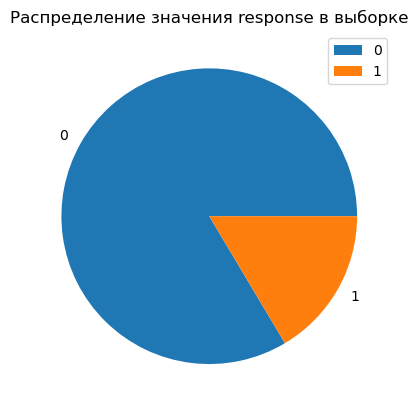

In [7]:
build_response_graph(class_train[class_result])

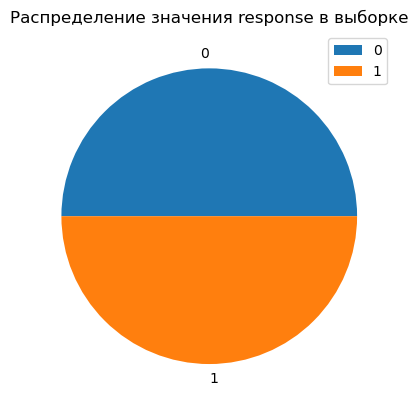

In [8]:
x = class_train[class_all]
y = class_train[class_result]
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)
build_response_graph(y)

Разобьём выборки на train и test

In [9]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size=0.3, random_state=7)
x = regression_train[regression_all]
y = regression_train[regression_result]
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение ансамблей моделей классификации

In [109]:
def test_bagging_model(estimators, parameters, x_train, y_train, x_test, y_test, is_bagg=True, is_regr=False):
    best_scores = []
    best_params = []
    for estimator in estimators:
        train_acc[str(estimator)] = []
        test_acc[str(estimator)] = []
        for parameter in parameters["n_estimators"]:
            if not is_regr:
                if is_bagg:
                    model = BaggingClassifier(estimator, n_estimators=parameter, random_state=42)
                else:
                    model = AdaBoostClassifier(estimator, n_estimators=parameter, random_state=42)
                model.fit(x_train, y_train)
                y_pred_train = model.predict_proba(x_train)[:, 1]
                # print(y_pred_train)
                y_pred_test = model.predict_proba(x_test)[:, 1]
                train_acc[str(estimator)].append(roc_auc_score(y_train, y_pred_train))
                test_acc[str(estimator)].append(roc_auc_score(y_test, y_pred_test))
            else:
                if is_bagg:
                    model = BaggingRegressor(estimator, n_estimators=parameter, random_state=42)
                else:
                    model = AdaBoostRegressor(estimator, n_estimators=parameter, random_state=42)
                model.fit(x_train, y_train)
                train_acc[str(estimator)].append(model.score(x_train, y_train))
                test_acc[str(estimator)].append(model.score(x_test, y_test))
        best_scores.append(max(test_acc[str(estimator)]))
        best_id = test_acc[str(estimator)].index(best_scores[-1])
        best_params.append(parameters["n_estimators"][best_id])
    best_score = max(best_scores)
    best_id = best_scores.index(best_score)
    best_param = best_params[best_id]
    print("Best parameter:", best_param)
    print("Best estimator:", estimators[best_id])
    print("Score:", best_score)
    return best_param

In [93]:
def plot_accuracy_graph(parameters, estimator_name, ax, train_acc, test_acc, regression=False):
    """
    Строит график зависимости точности от параметров модели
    :param parameters: список параметров
    :param parameter_name: название исследуемого параметра
    :param train_acc: производительность на тренировочной выборке
    :param test_acc: производительность на тестовой выборке
    :param cross_acc: производительность при перекрёстной проверке
    :param regression: используем ли модель регрессии
    """
    ax.plot(parameters, train_acc, label="Train")
    ax.plot(parameters, test_acc, label="Test")
    ax.set_xlabel("n_estimators", labelpad=15)
    ax.set_title(estimator_name)
    if not regression:
        ax.set_ylabel("ROC-AUC", labelpad=15)
    else:
        ax.set_ylabel("R^2", labelpad=15)
    ax.legend()

In [115]:
def build_graph(parameters, train_score, test_score, estimators, is_regression=False):
    fig, axs = plt.subplots(ncols=3, figsize=(20, 7))
    fig.subplots_adjust(hspace=0.4)
    plot_accuracy_graph(parameters, str(estimators[0]), axs[0], train_score[str(estimators[0])],
                        test_score[str(estimators[0])], regression=is_regression)
    plot_accuracy_graph(parameters, str(estimators[1]), axs[1], train_score[str(estimators[1])],
                        test_score[str(estimators[1])], regression=is_regression)
    plot_accuracy_graph(parameters, str(estimators[2]), axs[2], train_score[str(estimators[2])],
                        test_score[str(estimators[2])], regression=is_regression)

### Бэггинг

In [98]:
train_acc = {}
test_acc = {}
cross_val_acc = {}

In [100]:
parameters = {
    "n_estimators": range(30, 50, 3)
}
estimators = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB()]
test_bagging_model(estimators, parameters, x_train_c, y_train_c, x_test_c, y_test_c)

Best parameter: 48
Best estimator: DecisionTreeClassifier()
Score: 0.9709644060551197


48

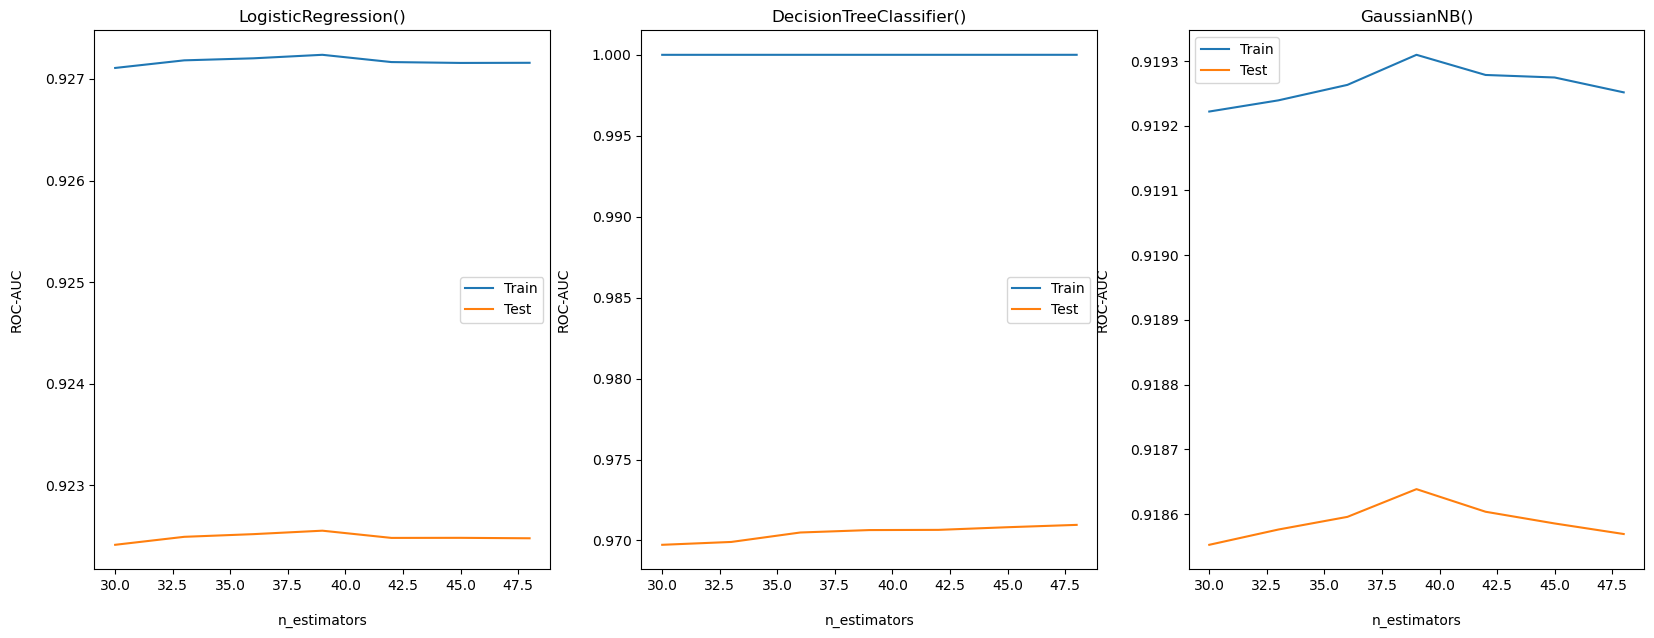

In [101]:
build_graph(parameters["n_estimators"], train_acc, test_acc, estimators)

### Бустинг

In [102]:
train_acc = {}
test_acc = {}
cross_val_acc = {}

In [103]:
parameters = {
    "n_estimators": range(30, 50, 3)
}
estimators = [LogisticRegression(), DecisionTreeClassifier(), GaussianNB()]
test_bagging_model(estimators, parameters, x_train_c, y_train_c, x_test_c, y_test_c, is_bagg=False)

Best parameter: 33
Best estimator: GaussianNB()
Score: 0.9210652798891797


33

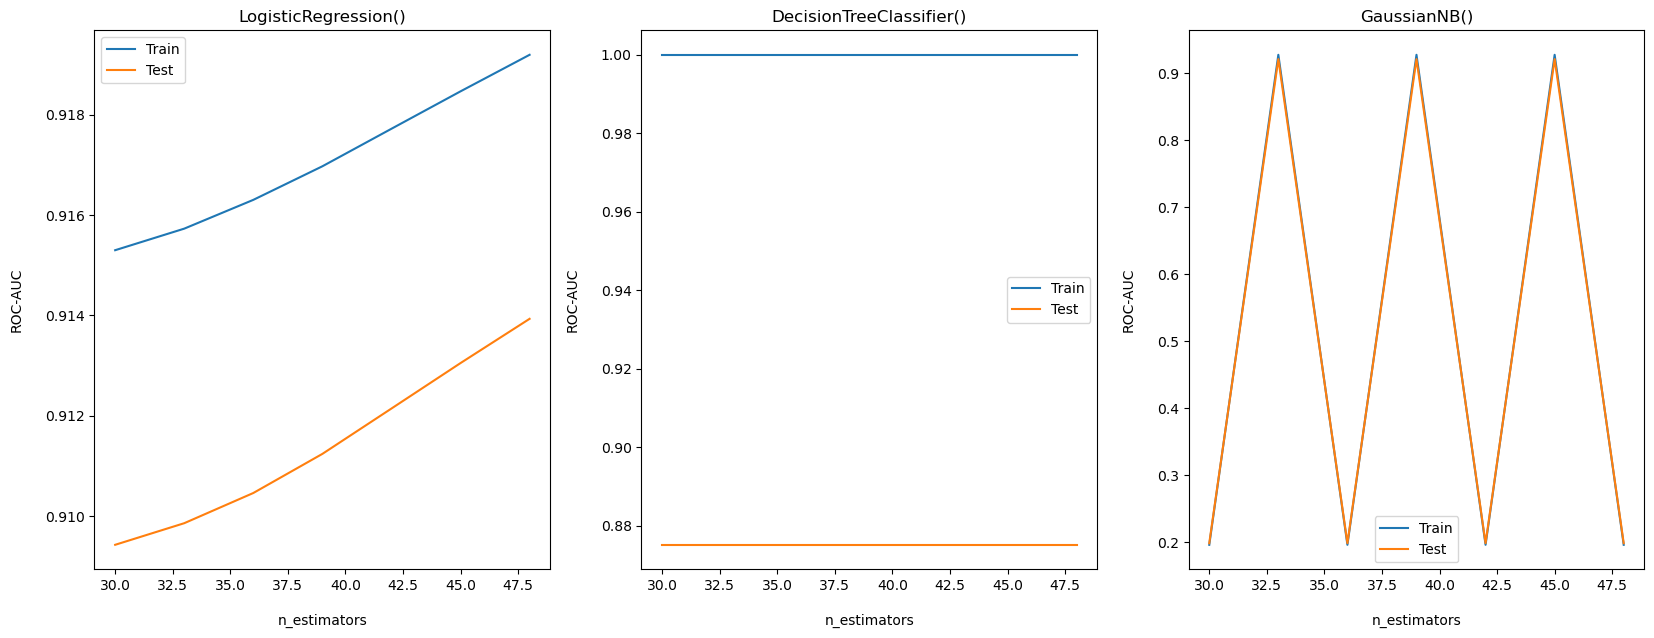

In [104]:
build_graph(parameters["n_estimators"], train_acc, test_acc, estimators)

### Стекинг

In [ ]:
estimators_clf = [
    ('knn', KNeighborsClassifier),
    ('lr', LogisticRegression),
    ('gnb', GaussianNB),
    ('lda', LinearDiscriminantAnalysis),
    ('rf', RandomForestClassifier),
    ('dt', DecisionTreeClassifier)
]

## Построение ансамблевых моделей регрессии

### Бэггинг

In [118]:
train_acc = {}
test_acc = {}
estimators = [DecisionTreeRegressor(), Lasso(), LinearRegression()]
test_bagging_model(estimators, parameters, x_train_r, y_train_r, x_test_r, y_test_r, is_regr=True)

Best parameter: 48
Best estimator: DecisionTreeRegressor()
Score: 0.9057578792017006


48

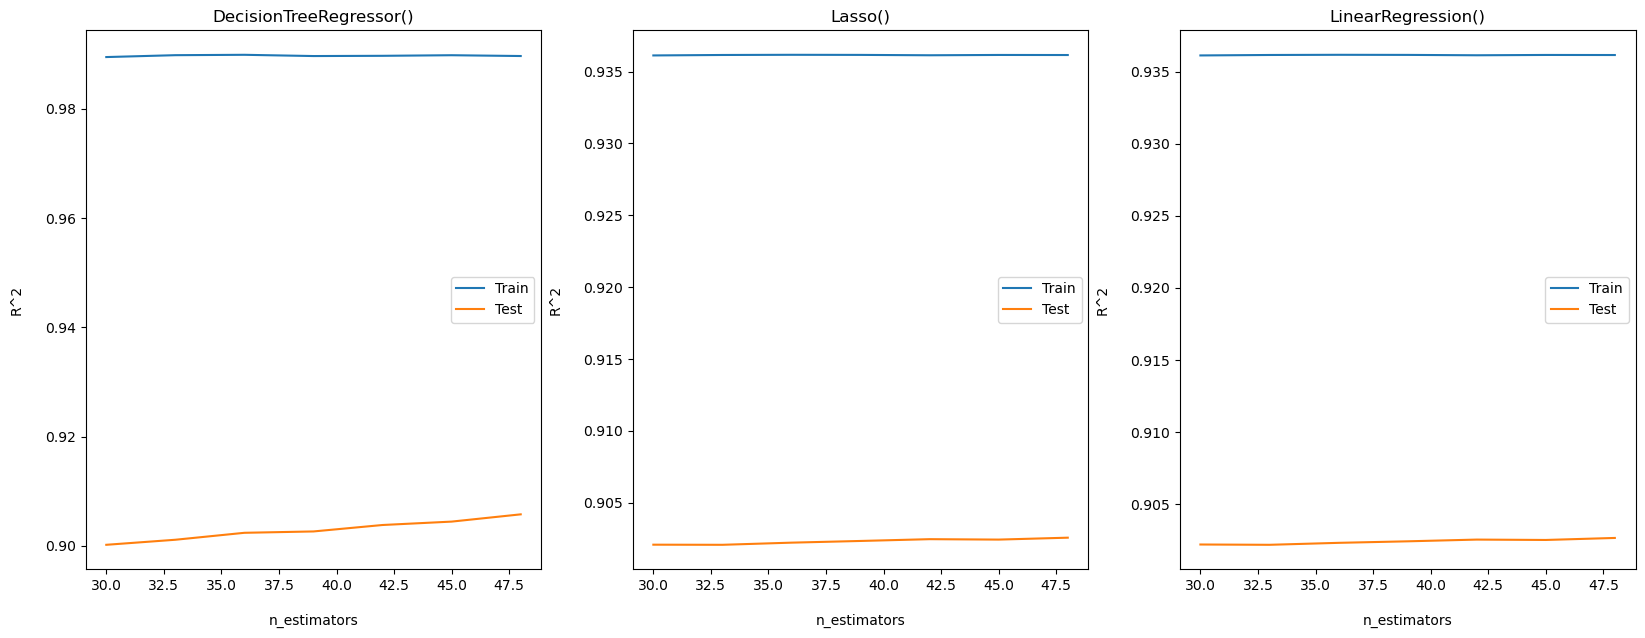

In [119]:
build_graph(parameters["n_estimators"], train_acc, test_acc, estimators, is_regression=True)

### Бустинг

In [113]:
train_acc = {}
test_acc = {}
cross_val_acc = {}
test_bagging_model(estimators, parameters, x_train_r, y_train_r, x_test_r, y_test_r, is_regr=True, is_bagg=False)

Best parameter: 33
Best estimator: DecisionTreeRegressor()
Score: 0.8971107616494116


33

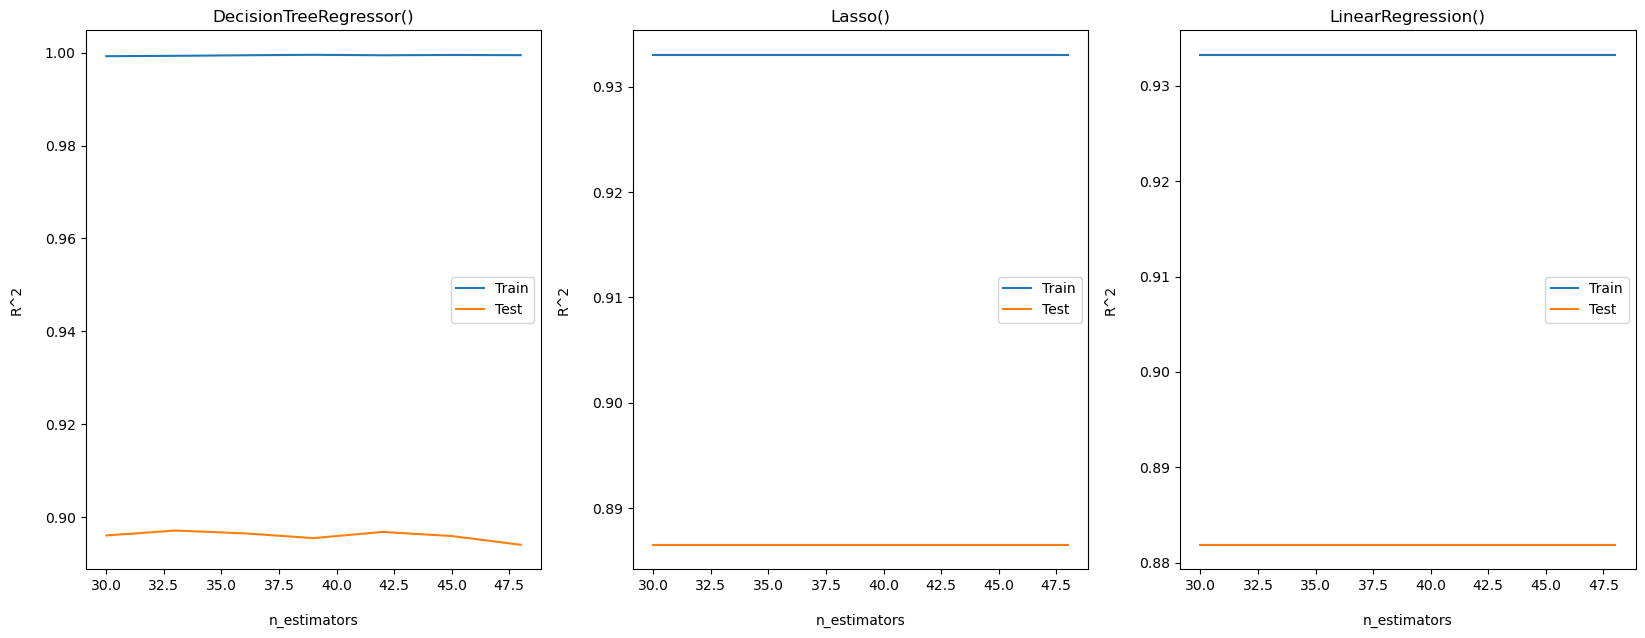

In [117]:
build_graph(parameters["n_estimators"], train_acc, test_acc, estimators, is_regression=True)